In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
%matplotlib inline

np.random.seed(69)

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import itertools

from keras.utils.np_utils import to_categorical # convert to one-hot-encoding
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from keras.optimizers import RMSprop
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau
from sklearn.preprocessing import LabelEncoder  


sns.set(style='white', context='notebook', palette='deep')

C:\Users\Antonios\Anaconda3\envs\my_root\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


C:\Users\Antonios\Anaconda3\envs\my_root\lib\site-packages\sklearn\preprocessing\label.py:111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Total of each class
 [368. 323. 463. 571. 382. 410. 204. 468. 314. 211. 206. 199. 188. 252.
 321. 268. 481. 479. 369. 220. 440. 293. 422. 376. 182. 264. 272. 420.
 288. 182. 164.]


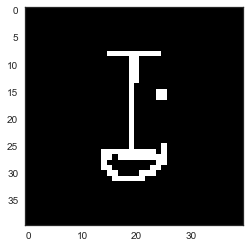

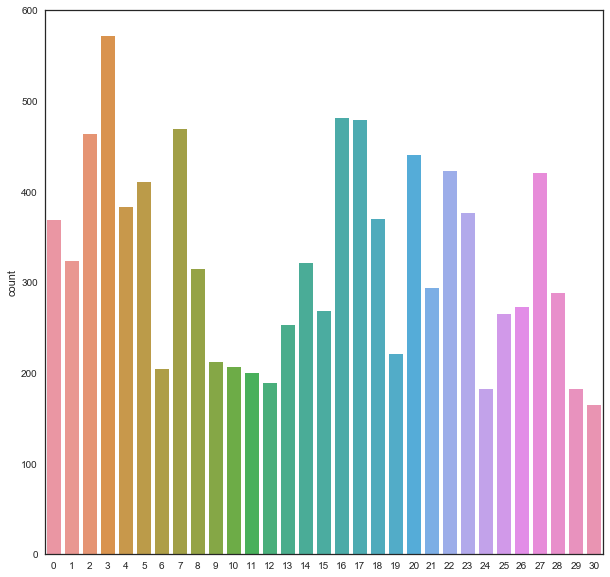

In [2]:
# Load the data
X = np.load("./Datasets/flat_processed_train_images.npy", encoding="bytes")
plt.imshow(X[0].reshape(40,40), cmap = 'gray')

y = np.reshape(pd.read_csv("Datasets/train_labels.csv").values[:, 1], (-1, 1))
#y = np.array(y, dtype = 'str')

# Prepare dataset
# Encode labels to one hot vectors
le = LabelEncoder()
y = to_categorical(le.fit_transform(y), num_classes = 31)

fig, ax = plt.subplots(figsize=(10,10))
g = sns.countplot(np.argmax(y, axis = 1))
print('Total of each class\n', np.sum(y, axis = 0))

X = X / 255.0
X = X.reshape(-1,40,40,1)

# Set the random seed
random_seed = 69

# Split the train and the validation set for the fitting
X_train, X_val, Y_train, Y_val = train_test_split(X, y, test_size = 0.1, random_state=random_seed)

# Some examples
# g = plt.imshow(X_train[0][:,:,0])

In [3]:
# Set the CNN model 
# my CNN architechture is In -> [[Conv2D->relu]*2 -> MaxPool2D -> Dropout]*2 -> Flatten -> Dense -> Dropout -> Out

model = Sequential()

model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu', input_shape = (40,40,1)))
model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.25))


model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu'))
model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
model.add(Dropout(0.25))


model.add(Flatten())
model.add(Dense(256, activation = "relu"))
model.add(Dropout(0.5))
model.add(Dense(31, activation = "softmax"))

In [4]:
# Define the optimizer
optimizer = RMSprop(lr=0.001, rho=0.9, epsilon=1e-08, decay=0.0)

In [5]:
# Compile the model
model.compile(optimizer = optimizer , loss = "categorical_crossentropy", metrics=["accuracy"])

In [6]:
# Set a learning rate annealer
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', 
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)

In [7]:
epochs = 20 # Turn epochs to 14 to get 0.67 accuracy
batch_size = 100

In [8]:
# # Without data augmentation i obtained an accuracy of 0.66
history = model.fit(X_train, Y_train, batch_size = batch_size, epochs = epochs, 
         validation_data = (X_val, Y_val), verbose = 2, callbacks=[learning_rate_reduction])

Train on 9000 samples, validate on 1000 samples
Epoch 1/20
 - 315s - loss: 2.6478 - acc: 0.2707 - val_loss: 1.8396 - val_acc: 0.4790
Epoch 2/20
 - 291s - loss: 2.0514 - acc: 0.4353 - val_loss: 1.6860 - val_acc: 0.5080
Epoch 3/20
 - 284s - loss: 1.8225 - acc: 0.4970 - val_loss: 1.5459 - val_acc: 0.5600
Epoch 4/20
 - 285s - loss: 1.6790 - acc: 0.5282 - val_loss: 1.4934 - val_acc: 0.5740
Epoch 5/20
 - 292s - loss: 1.5960 - acc: 0.5532 - val_loss: 1.5698 - val_acc: 0.5540
Epoch 6/20
 - 291s - loss: 1.5353 - acc: 0.5714 - val_loss: 1.3549 - val_acc: 0.6170
Epoch 7/20
 - 289s - loss: 1.4669 - acc: 0.5870 - val_loss: 1.3441 - val_acc: 0.6170
Epoch 8/20
 - 283s - loss: 1.4092 - acc: 0.5942 - val_loss: 1.3525 - val_acc: 0.6220
Epoch 9/20
 - 296s - loss: 1.3749 - acc: 0.6142 - val_loss: 1.4075 - val_acc: 0.6340
Epoch 10/20
 - 283s - loss: 1.3498 - acc: 0.6166 - val_loss: 1.3210 - val_acc: 0.6170
Epoch 11/20
 - 283s - loss: 1.2996 - acc: 0.6352 - val_loss: 1.2952 - val_acc: 0.6310
Epoch 12/20
 - 

In [9]:
# # With data augmentation to prevent overfitting (accuracy 0.6)

# datagen = ImageDataGenerator(
#         featurewise_center=False,  # set input mean to 0 over the dataset
#         samplewise_center=False,  # set each sample mean to 0
#         featurewise_std_normalization=False,  # divide inputs by std of the dataset
#         samplewise_std_normalization=False,  # divide each input by its std
#         zca_whitening=False,  # apply ZCA whitening
#         rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
#         zoom_range = 0.1, # Randomly zoom image 
#         width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
#         height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
#         horizontal_flip=False,  # randomly flip images
#         vertical_flip=False)  # randomly flip images


# datagen.fit(X_train)

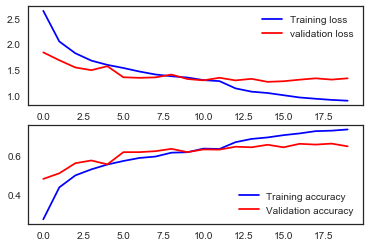

In [10]:
# Plot the loss and accuracy curves for training and validation 
fig, ax = plt.subplots(2,1)
ax[0].plot(history.history['loss'], color='b', label="Training loss")
ax[0].plot(history.history['val_loss'], color='r', label="validation loss",axes =ax[0])
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(history.history['acc'], color='b', label="Training accuracy")
ax[1].plot(history.history['val_acc'], color='r',label="Validation accuracy")
legend = ax[1].legend(loc='best', shadow=True)

In [16]:
model.save('model_non_aug.h5')  # creates a HDF5 file 'my_model.h5'

In [12]:
# # Fit the model 55% at 14 epochs, do more
# history = model.fit_generator(datagen.flow(X_train,Y_train, batch_size=batch_size),
#                               epochs = epochs, validation_data = (X_val,Y_val),
#                               verbose = 2, steps_per_epoch=X_train.shape[0] // batch_size
#                               , callbacks=[learning_rate_reduction])

In [13]:
# Plot the loss and accuracy curves for training and validation 
# fig, ax = plt.subplots(2,1)
# ax[0].plot(history.history['loss'], color='b', label="Training loss")
# ax[0].plot(history.history['val_loss'], color='r', label="validation loss",axes =ax[0])
# legend = ax[0].legend(loc='best', shadow=True)

# ax[1].plot(history.history['acc'], color='b', label="Training accuracy")
# ax[1].plot(history.history['val_acc'], color='r',label="Validation accuracy")
# legend = ax[1].legend(loc='best', shadow=True)

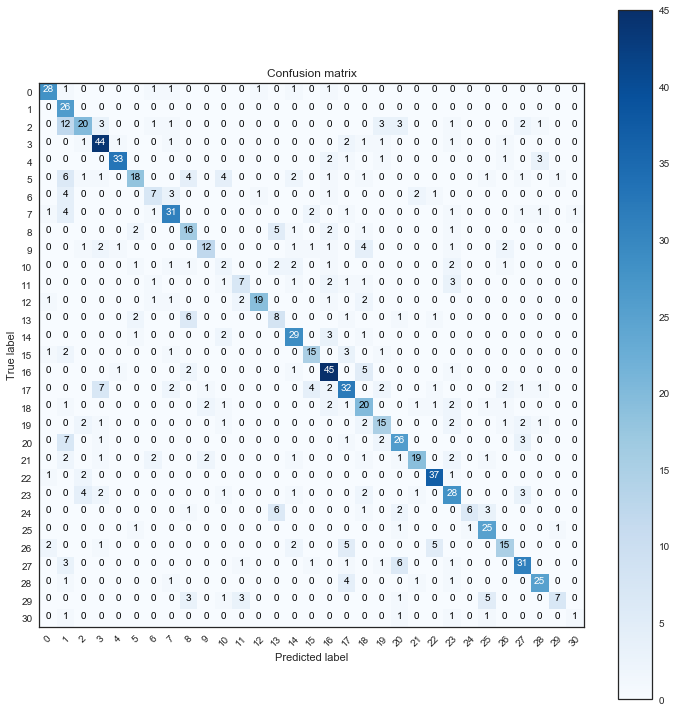

In [14]:
# Look at confusion matrix 

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.figure(figsize=(10,10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Predict the values from the validation dataset
Y_pred = model.predict(X_val)
# Convert predictions classes to one hot vectors 
Y_pred_classes = np.argmax(Y_pred,axis = 1) 
# Convert validation observations to one hot vectors
Y_true = np.argmax(Y_val,axis = 1) 
# compute the confusion matrix
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 
# plot the confusion matrix
plot_confusion_matrix(confusion_mtx, classes = range(31)) 

In [15]:
#model.save('model_aug.h5')  # creates a HDF5 file 'my_model.h5'